In [5]:
import deeptrack as dt

ModuleNotFoundError: No module named 'deeptrack'

In [5]:
import cv2
import scipy.io
import numpy as np
from PIL import Image
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

ModuleNotFoundError: No module named 'deeptrack'

In [ ]:
class Preprocessor():

  def __init__(self,
               scales=[1, 2, 4]
               ):
    self.scales = scales

  
  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image

  def normalizate(self, image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    return normalized_image

  def resize(self, image, scale):
    resized_image = cv2.resize(image, (0, 0), fx=1/scale, fy=1/scale)

    return resized_image

  def generate_pipeline(self, image, transformations):
    pipeline = dt.Value(image)
    for transformation in transformations:
      pipeline = pipeline >> transformation

    return pipeline

  def create_train_data(self, image):
    normalized_image = self.normalizate(image)
    training_image = np.expand_dims(normalized_image, axis = -1)

    train_set = (self.generate_pipeline(training_image, transformations))
    train_set.plot()

    return train_set

  def load_images(self, data, plot=True):
    dataset = [self.resize(data, scale) for scale in self.scales]
    input_set = [self.normalizate(image) for image in dataset]

    if plot:
      fig, ax = plt.subplots(1, len(input_set), figsize=(25,5))
      fig.tight_layout()
      fig.suptitle('Scaled 3D images')
      for index in range(len(input_set)):
        ax[index].imshow(input_set[index])
    
    return input_set

# --------------------------------------------------------------------
class Trainer():

  def __init__(self,
               filepath,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               callbacks = [None]
               ):

    self.model = model
    self.filepath = filepath
    self.callbacks = [
        ModelCheckpoint(filepath=self.filepath,
                        save_weights_only=True,
                        monitor='consistency_loss',
                        mode='min',
                        save_best_only=True
                        ),
        EarlyStopping(monitor="total_loss",
                      patience=15,
                      verbose=1,
                      mode="auto",
                      restore_best_weights=True
                      ),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))
    ]
  
  def fit(self, train_set, epochs=40, batch_size=8):
    history = self.model.fit(
        train_set,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = self.callbacks)

    return history

  def plot_performance(self, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()

# --------------------------------------------------------------------
class Detector():

  def __init__(self,
               downsample,
               alpha = 0.1,
               cutoff = 0.998,
               mode = "quantile",
               colors = 'rgb',
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               ):
    self.downsample = downsample
    self.alpha = alpha
    self.cutoff = cutoff
    self.mode = mode
    self.colors = colors
    self.model = model

  def detect(self, image, plot=True):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=self.alpha, beta=1-self.alpha, cutoff=self.cutoff, mode=self.mode)[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections

  def detect_all(self, images, plot=False):
    detections = []
    
    if plot:
      fig, ax = plt.subplots(1, len(images), figsize=(25, 5))
      fig.tight_layout()
      fig.suptitle('Detections')
    
    for index in range(len(images)):
      det = self.detect(image=images[index])
      detections.append(det)

      if plot:
        ax[index].imshow(images[index])
        ax[index].scatter(detections[index][:, 1], detections[index][:, 0], color=self.colors[index])
      
    return detections

# --------------------------------------------------------------------
class Postprocessor():

  def __init__(self,
               wide=50,
               scales=[1, 2, 4],
               colors = 'rgb'
               ):
    self.wide = wide
    self.scales = scales
    self.colors = colors
  
  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()

  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds

  def NMSupression(self, boxes, overlapThresh):
    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
      
    return boxes[pick].astype("int")

  def apply_nms(self, image, list_bounds, overlapThresh=0.3):
    all_bounds = [bounds.tolist() for bounds in list_bounds]
    final_bounds = []

    for index in range(len(all_bounds)):
      final_bounds += all_bounds[index]

    final_bounds = np.array(final_bounds)
    final_detections = self.NMSupression(final_bounds,
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections)

    return final_detections


  def plot_boxes(self, test_image, detections, plot=True):
    list_boxes, list_bounds, scaled_detections = [], [], []

    if plot:
      fig, ax = plt.subplots(figsize=(15, 15))
      plt.imshow(test_image)

    for index in range(len(detections)):
      scaled_det = self.scale_detections(detections[index], self.scales[index])
      scaled_detections.append(scaled_det)

      boxes, bounds = self.create_boxes(scaled_detections[index])
      list_boxes.append(boxes)
      list_bounds.append(bounds)

      if plot:
        boxes.boundary.plot(ax=ax, color = self.colors[index])

    return list_bounds

  def plot_results(self, image, boxes, color='red', lw=4):
    plt.figure(figsize=(15, 15))
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)
     
      plt.gca().add_patch(rect)

### Ground-truth creation

In [112]:
# Función para dibujar un cuadro delimitador en una imagen
def draw_box(event, x, y, flags, param):
    global x_init, y_init, drawing, top_left_pt, bottom_right_pt, box_coords, box_size

    # Si se hace clic con el botón izquierdo, comenzar a dibujar
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x_init, y_init = x, y

    # Si el botón izquierdo está levantado, dibujar el cuadro delimitador
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x_diff, y_diff = x - x_init, y - y_init
        half_box_size = int(box_size / 2)
        top_left_pt = (x - half_box_size, y - half_box_size)
        bottom_right_pt = (x + half_box_size, y + half_box_size)
        cv2.rectangle(image, top_left_pt, bottom_right_pt, (0,0,255), 3)
        box_coords.append({'x1': top_left_pt[0], 'y1': top_left_pt[1],
                           'x2': bottom_right_pt[0], 'y2': bottom_right_pt[1]})

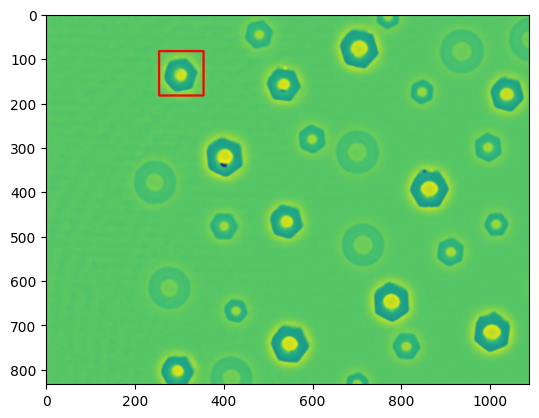

In [125]:
# Cargar imagen para procesar con OpenCV
image = plt.imread(path)

# Definir el tamaño del cuadro delimitador
box_size = 100

# Mostrar la imagen en una ventana
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw_box)

drawing = False
x_init, y_init = 0, 0
top_left_pt, bottom_right_pt = (0, 0), (0, 0)
box_coords = []

while True:
    cv2.imshow('image', image)
    k = cv2.waitKey(1)

    # Si se presiona la tecla 'q', salir
    if k == ord('q'):
        break

# Dibujar los bounding boxes
for box in box_coords:
    cv2.rectangle(image, (box['x1'], box['y1']), (box['x2'], box['y2']), (255, 0, 0), thickness=3)

cv2.destroyAllWindows()

# Mostrar la imagen con los bounding boxes
plt.imshow(image)

In [127]:
# Mostrar las coordenadas de los bounding boxes
print(box_coords[0])

{'x1': 254, 'y1': 83, 'x2': 354, 'y2': 183}


### Loading pre-trained weight

In [ ]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/checkpoint_test_class1'
trainer1 = Trainer(filepath)
trainer1.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
trainer1.model.load_weights(filepath)

### Testing

In [ ]:
reconstruction_path = f'/content/drive/MyDrive/Investigacion/Data/MATLAB/output/smoothed'
n_images = 8
test_set = [scipy.io.loadmat(f'{reconstruction_path}/reconstruction0{num}.mat')['Spz'] for num in range(1,n_images+1)]
len(test_set)

In [ ]:
def test(test_data, model, downsample=1, alpha=0.1, cutoff=0.99, mode="quantile", plotPrevious=True):
  preprocessor = Preprocessor()
  input_set = preprocessor.load_images(test_data, plot=plotPrevious)
  detector = Detector(downsample, model=model, alpha=alpha, cutoff=cutoff, mode=mode)
  detections = detector.detect_all(input_set, plot=plotPrevious)
  postprocessor = Postprocessor()
  test_image = input_set[0]
  bounds = postprocessor.plot_boxes(test_image, detections, plot=plotPrevious)
  final_detections = postprocessor.apply_nms(test_image, bounds)

  return final_detections

In [ ]:
# Detection settings
alpha = 0.1 # 0.1
cutoff = 0.99 # 0.99
mode = "quantile"

In [ ]:
final_detections = test(test_set[0], trainer1.model, downsample=2, alpha=alpha, cutoff=cutoff, plotPrevious=False)

In [ ]:
for idx in range(len(test_set)):
    final_detections = test(test_set[idx], trainer1.model, downsample=2, alpha=alpha, cutoff=cutoff, plotPrevious=False)